<a href="https://colab.research.google.com/github/Priesemann-Group/covid19_inference_forecast/blob/cleaning_code/scripts/example_script_covid19_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
!pip install git+https://github.com/Priesemann-Group/covid19_inference_forecast.git@cleaning_code

In [82]:
import sys
sys.path.append('..')
import datetime

import numpy as np
import pymc3 as pm

import covid19_inference as cov19

confirmed_cases = cov19.get_jhu_confirmed_cases()

date_data_begin = datetime.datetime(2020,3,1)
date_data_end   = cov19.get_last_date(confirmed_cases)
#date_data_end   = datetime.datetime(2020,3,28)
num_days_data = (date_data_end-date_data_begin).days
diff_data_sim = 12 # should be significantly larger than the expected delay, in 
                   # order to always fit the same number of data points.
num_days_future = 14
date_begin_sim = date_data_begin - datetime.timedelta(days = diff_data_sim)
date_end_sim   = date_data_end   + datetime.timedelta(days = num_days_future)
num_days_sim = (date_end_sim-date_begin_sim).days


cases_obs = cov19.filter_one_country(confirmed_cases, 'Germany',
                                     date_data_begin, date_data_end)

change_points = [dict(prior_mean_date_begin_transient = datetime.datetime(2020,3,9),
                      prior_median_λ = 1),
                 dict(prior_mean_date_begin_transient = datetime.datetime(2020,3,16),
                      prior_sigma_date_begin_transient = 1,
                      prior_median_λ = 0.5,
                      prior_sigma_λ = 0.5),
                 dict(prior_mean_date_begin_transient = datetime.datetime(2020,3,23),
                      prior_sigma_date_begin_transient = 1,
                      prior_median_λ = 0.1,
                      prior_sigma_λ = 0.3)]

model = cov19.more_advanced_model(np.diff(cases_obs),
                                                       change_points,
                                                       date_begin_sim,
                                                       num_days_sim,
                                                       diff_data_sim,
                                 priors_dic=dict(prior_σ_random_walk=0.1))

trace = pm.sample(model=model, init='advi', tune=2000, draws=5000, chains=6, cores=6)


prior_beta_I_begin was to default value 100
prior_beta_E_begin_scale was to default value 10
prior_median_λ_0 was to default value 2
prior_sigma_λ_0 was to default value 0.7
prior_median_μ was to default value 0.3333333333333333
prior_sigma_μ was to default value 0.3
prior_median_delay was to default value 5
prior_sigma_delay was to default value 0.2
scale_delay was to default value 0.3
prior_beta_σ_obs was to default value 10
prior_mean_median_incubation was to default value 5
prior_sigma_median_incubation was to default value 1
sigma_incubation was to default value 0.418
prior_sigma_λ of change point 0 was set to default value 0.7
prior_sigma_date_begin_transient of change point 0 was set to default value 3
prior_median_transient_len of change point 0 was set to default value 3
prior_median_transient_len of change point 1 was set to default value 3
prior_median_transient_len of change point 2 was set to default value 3
prior_sigma_transient_len of change point 0 was set to default va

INFO (theano.gof.compilelock): Refreshing lock /home/jdehning/.theano/compiledir_Linux-4.18--generic-x86_64-with-debian-buster-sid-x86_64-3.7.6-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average Loss = 322.1:  16%|█▌        | 32080/200000 [01:45<09:09, 305.42it/s]    
Convergence achieved at 32100
Interrupted at 32,099 [16%]: Average Loss = 25,051
INFO (theano.gof.compilelock): Refreshing lock /home/jdehning/.theano/compiledir_Linux-4.18--generic-x86_64-with-debian-buster-sid-x86_64-3.7.6-64/lock_dir/lock
Multiprocess sampling (6 chains in 6 jobs)
NUTS: [median_incubation, σ_obs, delay, μ, λ_t_random_walk, σ_random_walk, transient_len_2, transient_len_1, transient_len_0, transient_begin_2, transient_begin_1, transient_begin_0, λ_3, λ_2, λ_1, λ_0, E_begin, E_begin_scale, I_begin]
Sampling 6 chains, 0 divergences:  18%|█▊        | 7598/42000 [23:36<1:32:39,  6.19draws/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending out

In [83]:
trace2 = pm.sample(model=model, init='advi+adapt_diag', tune=2000, draws=5000, chains=6, cores=6)


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Average Loss = 3,354.5:   6%|▋         | 12827/200000 [00:43<10:30, 296.70it/s]  IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Sampling 6 chains, 224 divergences:  58%|█████▊    | 24429/42000 [43:58<36:11,  8.09draws/s]  IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [70]:
#from theano.compile.nanguardmode import NanGuardMode

#mode = NanGuardMode(nan_is_error=True, inf_is_error=False, big_is_error=False,
#                    optimizer='o1')
with model:
    vi = pm.SVGD(n_particles=200)
    tracker = pm.callbacks.Tracker(
        mean=vi.approx.mean.eval,  # callable that returns mean
        std=vi.approx.std.eval  # callable that returns std
    )
    approx = vi.fit(1000, obj_optimizer=pm.adam(learning_rate=0.1))#, inf_kwargs=dict(n_particles=1000),
                         #obj_optimizer=pm.sgd(learning_rate=0.01))#, fn_kwargs={'mode':mode})
    trace = approx.sample(1000)

100%|██████████| 1000/1000 [06:30<00:00,  2.56it/s]


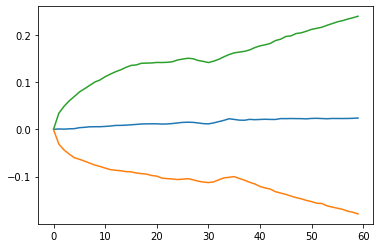

In [88]:
#plt.plot(np.median(trace.λ_t, axis=0))
plt.plot(np.median(trace2.λ_t_random_walk, axis=0))
plt.plot(np.percentile(trace2.λ_t_random_walk, axis=0, q=(12.5,87.5)).T)

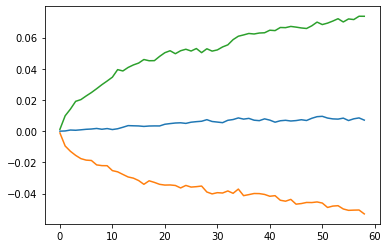

In [78]:
#plt.plot(np.median(trace.λ_t-trace.λ_t_random_walk, axis=0))
plt.plot(np.median(trace.λ_t_random_walk, axis=0))
plt.plot(np.percentile(trace.λ_t_random_walk, axis=0, q=(12.5,87.5)).T)

Dimension of E_begin larger than one, skipping
Dimension of λ_t_random_walk larger than one, skipping


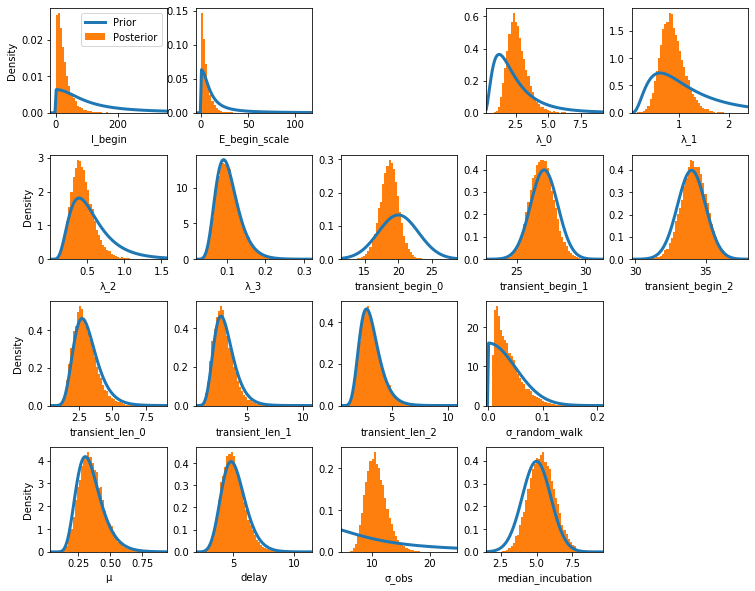

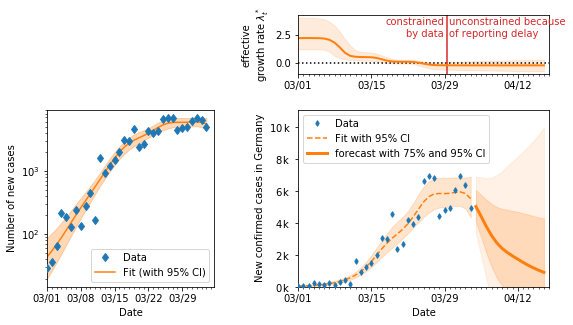

In [87]:
varnames = cov19.plotting.get_all_free_RVs_names(model)
num_cols = 5
num_rows = int(np.ceil(len(varnames)/num_cols))
x_size = num_cols * 2.5
y_size = num_rows * 2.5

fig, axes = plt.subplots(num_rows, num_cols, figsize = (x_size, y_size),squeeze=False)
i_ax = 0
for i_row, axes_row in enumerate(axes):
    for i_col, ax in enumerate(axes_row):
        if i_ax >= len(varnames):
            ax.set_visible(False)
            continue 
        else:
            cov19.plotting.plot_hist(model, trace, ax, varnames[i_ax])
        if not i_col == 0:
            ax.set_ylabel('')
        if i_col == 0 and i_row == 0:
            ax.legend()
        i_ax += 1
fig.subplots_adjust(wspace=0.25, hspace=0.4)
fig, axes = cov19.plotting.plot_cases(trace, np.diff(cases_obs), date_begin_sim, diff_data_sim)